# LOADING DATASET

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Load data
menu = pd.read_csv('../Data/manu_FC.csv')
orders = pd.read_csv('../Data/selling_transactions.csv')
inventory = pd.read_csv('../Data/inventory_waste.csv')
recipes = pd.read_csv('../Data/recipes.csv')

# Display DF heads
print("Menu DF:")
display(menu.head())
print("Orders DF:")
display(orders.head())
print("Inventory DF:")
display(inventory.head())
print("Recipes DF:")
display(recipes.head())

Menu DF:


,item_id,item_name,category,theoretical_cost,target_margin,is_active
0,ANT-001,Bruschetta al pomodoro,Antipasti,1.8,74,True
1,ANT-002,Caprese,Antipasti,2.5,72,True
2,ANT-003,Prosciutto e melone,Antipasti,3.2,71,True
3,ANT-004,Affettati misti,Antipasti,4.0,69,True
4,PIZ-001,Margherita,Pizze,2.1,77,True


Orders DF:


,transaction_id,timestamp,store_id,item_id,channel,qty,total_net_price
0,TXN-000001,2024-01-01 20:22:00,MIL-01,PIZ-002,Glovo,2,16.0
1,TXN-000002,2024-01-01 13:52:00,MIL-01,BEV-005,Sala,2,3.0
2,TXN-000003,2024-01-01 21:54:00,MIL-01,PRI-003,Deliveroo,2,26.0
3,TXN-000004,2024-01-01 20:51:00,MIL-01,SEC-005,Take-away,2,32.0
4,TXN-000005,2024-01-01 13:02:00,MIL-01,PIZ-007,Deliveroo,1,15.0


Inventory DF:


,date,store_id,item_id,ingredient_name,waste_type,waste_qty,waste_value
0,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Scaduto,0.98,0.78
1,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Sfrido,1.33,1.06
2,2024-01-01,MIL-01,VER-01,Verdure miste (kg),Deteriorato,1.30,4.55
3,2024-01-01,MIL-02,PRO-01,Prosciutto crudo (kg),Errore Comanda,1.92,42.24
4,2024-01-01,MIL-02,VER-01,Verdure miste (kg),Sfrido,1.85,6.48


Recipes DF:


,dish_id,dish_name,ingredient_id,ingredient_name,quantity,unit,costo_unitario,costo_ingrediente
0,ANT-001,Bruschetta al pomodoro,TOM-01,Pomodoro pelato,0.080,kg,1.2,0.10
1,ANT-001,Bruschetta al pomodoro,OLI-01,Olio EVO,0.015,lt,5.0,0.07
2,ANT-001,Bruschetta al pomodoro,BAS-01,Basilico,0.300,mazzo,1.5,0.45
3,ANT-002,Caprese,MOZZ-01,Mozzarella fior di latte,0.125,kg,5.5,0.69
4,ANT-002,Caprese,TOM-01,Pomodoro pelato,0.150,kg,1.2,0.18


### **Dfs are quite balanced in some features, so I decided augmenting data for better analysis**

In [5]:
# -- 1. First injection: augmenting sales data --
def inject_realism_full(sales_df, inventory_df, menu_df):
    
    # Work on copies to avoid modifying original data
    sales_df = sales_df.copy()
    inventory_df = inventory_df.copy()
    
    # --- 1. SETTING SCENARIO ---
    sales_scenario = {
        'Acqua naturale':       {'qty': 4.0, 'price': 1.0},
        'Caffè':                {'qty': 3.5, 'price': 1.0},
        'Spritz':               {'qty': 2.0, 'price': 1.2},
        'Vino rosso (calice)':  {'qty': 1.5, 'price': 1.1},
        'Birra media':          {'qty': 2.5, 'price': 1.0},
        'Margherita':           {'qty': 3.0, 'price': 1.0},
        'Diavola':              {'qty': 0.6, 'price': 1.0},
        'Marinara':             {'qty': 0.2, 'price': 1.0},
        'Pizza gourmet tartufo':{'qty': 0.4, 'price': 1.5},
        'Bufala e pachino':     {'qty': 1.2, 'price': 1.2},
        'Carbonara':            {'qty': 2.2, 'price': 1.0},
        'Amatriciana':          {'qty': 1.8, 'price': 1.0},
        'Cacio e pepe':         {'qty': 1.5, 'price': 1.1},
        'Branzino al forno':    {'qty': 0.8, 'price': 1.3},
        'Tagliata di manzo':    {'qty': 0.7, 'price': 1.4},
        'Cotoletta alla milanese': {'qty': 1.5, 'price': 1.1},
        'Tiramisù':             {'qty': 2.0, 'price': 1.0},
        'Panna cotta':          {'qty': 0.5, 'price': 1.0},
    }

    waste_scenario = {
        'Mozzarella (kg)':          3.5,
        'Pesce branzino (kg)':      4.0,
        'Verdure miste (kg)':       2.5,
        'Prosciutto crudo (kg)':    1.5,
        'Carne manzo (kg)':         1.2,
        'Salame piccante (kg)':     1.8,
        'Funghi porcini (kg)':      1.3,
        'Farina tipo 00 (kg)':      0.2,
        'Olio EVO (lt)':            0.1,
        'Pomodoro San Marzano (kg)':0.3,
    }

    # --- 2. APPLYING SALES LOGIC ---
    sales_df['unit_price_temp'] = sales_df['total_net_price'] / sales_df['qty']
    
    for item_name, multipliers in sales_scenario.items():
        try:
            target_ids = menu_df.loc[menu_df['item_name'] == item_name, 'item_id'].values
            if len(target_ids) > 0:
                t_id = target_ids[0]
                mask = sales_df['item_id'] == t_id
                
                if mask.any():
                    sales_df.loc[mask, 'qty'] *= multipliers['qty']
                    new_price = sales_df.loc[mask, 'unit_price_temp'] * multipliers['price']
                    sales_df.loc[mask, 'total_net_price'] = sales_df.loc[mask, 'qty'] * new_price
        except Exception as e:
            print(f"Skipping {item_name}: {e}")

    sales_df.drop(columns=['unit_price_temp'], inplace=True)

    # --- 3. APPLYING WASTE LOGIC ---
    # Adding random noise to waste quantities
    inventory_df['waste_qty'] *= 1.0 
    
    # setting known multipliers for specific ingredients
    known_mapping = {
        'MOZZ-01': 3.5, # Mozzarella
        'PES-01':  4.0, # Branzino
        'FAR-01':  0.2, # Farina
        'SAL-01':  1.8, # Salame
        'OLI-01':  0.1, # Olio
        'TOM-01':  0.3, # Pomodoro
        'FUN-01':  1.3  # Funghi
    }
    
    for ing_id, mult in known_mapping.items():
        col_name = 'ingredient_id' if 'ingredient_id' in inventory_df.columns else 'item_id'
        mask = inventory_df[col_name] == ing_id
        
        if mask.any():
            inventory_df.loc[mask, 'waste_qty'] *= mult
            inventory_df.loc[mask, 'waste_value'] *= mult

    print("Data unbalanced correctly!")
    
    return sales_df, inventory_df

orders, inventory = inject_realism_full(orders, inventory, menu)

# ---------------------------------------------------------------------------- #

# -- 2. Second injection: augmenting with associations for cross selling--
def inject_associations(sales_df, menu_df):
    print("---INJECTION ASSOCIATIONS (Cross-Selling) ---")
    
    # 1. Let's define the pairs we want to force into the Heatmap
    # (Trigger Item) -> (Target Item that we add)
    combos = [
        # DIAVOLA-SAVING COMBO: Whoever takes the Diavola drinks Beer (to turn off the heat)
        {'trigger': 'Diavola', 'target': 'Birra media', 'prob': 0.85}, 
        
        # CLASSIC COMBO: Whoever takes Tiramisu takes Coffee
        {'trigger': 'Tiramisù', 'target': 'Caffè', 'prob': 0.90},
        
        # APERITIF COMBO: Those who take Spritz order Chips (or Grilled Vegetables if you don't have chips)
        {'trigger': 'Spritz', 'target': 'Verdure grigliate', 'prob': 0.70},
        
        # ROMAN COMBO: Carbonara calls Red Wine
        {'trigger': 'Carbonara', 'target': 'Vino rosso (calice)', 'prob': 0.80}
    ]
    
    new_rows = []
    
    # Looping on rules
    for combo in combos:
        trigger_name = combo['trigger']
        target_name = combo['target']
        probability = combo['prob']
        
        # Finding IDs
        try:
            trigger_id = menu_df.loc[menu_df['item_name'] == trigger_name, 'item_id'].values[0]
            target_id = menu_df.loc[menu_df['item_name'] == target_name, 'item_id'].values[0]
        except IndexError:
            print(f"Skipping combo {trigger_name}+{target_name}: ID non trovato.")
            continue
            
        # Finding all receipts (transaction_id) that contain the TRIGGER
        trigger_transactions = sales_df.loc[sales_df['item_id'] == trigger_id, 'transaction_id'].unique()
        
        print(f"Trovati {len(trigger_transactions)} scontrini con {trigger_name}. Inietto {target_name}...")
        
       # For each receipt, deciding whether to add the TARGET
        count_added = 0
        for t_id in trigger_transactions:
            # Rolling a die (random) based on the probability
            if np.random.rand() < probability:
               # Check if it's already there so as not to duplicate
                existing_items = sales_df.loc[sales_df['transaction_id'] == t_id, 'item_id'].values
                
                if target_id not in existing_items:
                    # Creating a new row for the TARGET item
                    new_row = {
                        'transaction_id': t_id,
                        'item_id': target_id,
                        'qty': 1.0, 
                        'total_net_price': 5.0, 
                        'item_name': target_name 
                    }
                    new_rows.append(new_row)
                    count_added += 1
        
        print(f" -> Aggiunte {count_added} righe di {target_name}.")

    # Adding new rows to the sales_df
    if len(new_rows) > 0:
        new_df = pd.DataFrame(new_rows)
        # Concateniamo
        sales_df = pd.concat([sales_df, new_df], ignore_index=True)
    
    print("--- ASSOCIATIONS INJECTED SUCCESSFULLY ---")
    return sales_df

# --- EXECUTION ---
orders_c = orders.copy()
orders_c = inject_associations(orders_c, menu)

/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_67625/2106488565.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.  7.  7.  ... 7.  7.  3.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sales_df.loc[mask, 'qty'] *= multipliers['qty']


Data unbalanced correctly!
---INJECTION ASSOCIATIONS (Cross-Selling) ---
Trovati 4292 scontrini con Diavola. Inietto Birra media...
 -> Aggiunte 3607 righe di Birra media.
Trovati 4210 scontrini con Tiramisù. Inietto Caffè...
 -> Aggiunte 3788 righe di Caffè.
Trovati 4241 scontrini con Spritz. Inietto Verdure grigliate...
 -> Aggiunte 2987 righe di Verdure grigliate.
Trovati 4336 scontrini con Carbonara. Inietto Vino rosso (calice)...
 -> Aggiunte 3472 righe di Vino rosso (calice).
--- ASSOCIATIONS INJECTED SUCCESSFULLY ---


# SECOND PILLAR - CROSS SELLING

/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_67625/2837909420.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


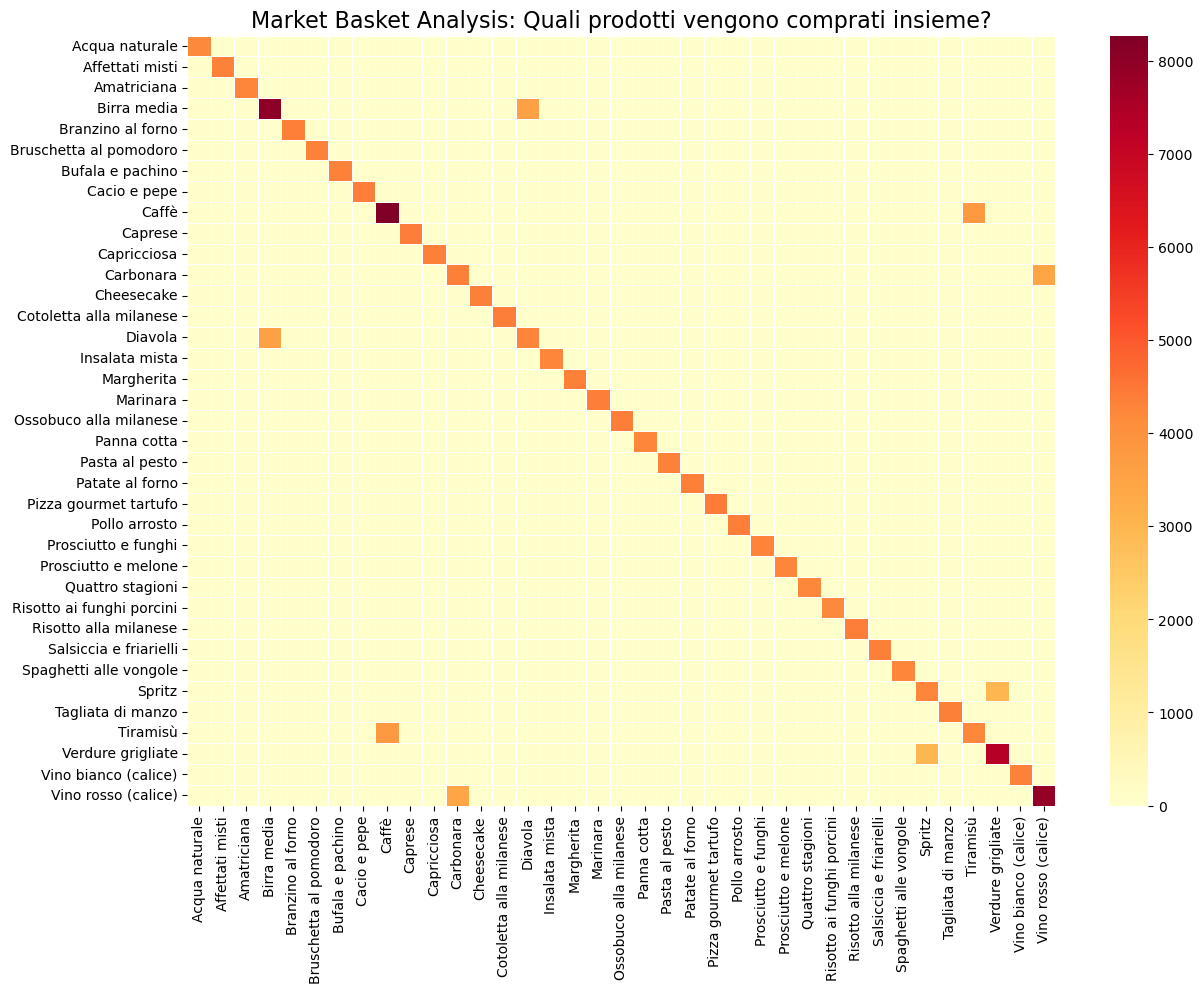


--- Best Friends of DIAVOLA are:---
item_name
Birra media              3607
Acqua naturale              0
Risotto alla milanese       0
Pizza gourmet tartufo       0
Pollo arrosto               0
Name: Diavola, dtype: int64


In [6]:
# 1. DATA PREPARATION
# grouping ordered dishes by transaction count
joined_tables = pd.merge(orders_c, menu[['item_id', 'item_name']], on='item_id', how='left').rename(columns={'item_name_y': 'item_name'}).drop(columns=['item_name_x'])
orders_filtered = joined_tables[['transaction_id', 'item_id', 'item_name', 'qty']].copy() 

# 2. CREATION THE "BASKET MATRIX" (One-Hot Encoding)
basket = orders_filtered.groupby(['transaction_id', 'item_name'])['qty'].sum().unstack().fillna(0)

# Converting everything to 1 (presence) or 0 (absence), it doesn't care if he took 3, we just need him to take it.
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# 3. CO-OCCURRENCE MATRIX
cooccurrence_matrix = basket.T.dot(basket) 

# 4. VISUALIZZATION (HEATMAP)
plt.figure(figsize=(14, 10))
sns.heatmap(
    cooccurrence_matrix, 
    annot=False,       
    cmap="YlOrRd",    
    linewidths=.5
)
plt.title('Market Basket Analysis: Quali prodotti vengono comprati insieme?', fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.show()

# 5. INSIGHT EXTRAXCTION
target_item = 'Diavola' # passing all dog dishes. to see who is the best friend of Diavola in the menu

if target_item in cooccurrence_matrix.columns:
    associations = cooccurrence_matrix[target_item].sort_values(ascending=False).drop(target_item) 
    print(f"\n--- Best Friends of {target_item.upper()} are:---")
    print(associations.head(5))
else:
    print(f"Warning: '{target_item}' not found in menu.")
